In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
df = pd.read_csv('/content/iris.csv')
df['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [30]:
class IrisDataset:
  def __init__(self, iris_csv):
    self.iris_csv = iris_csv
    self.df = pd.read_csv(iris_csv)
    self.preprocessing()

  def get_map_dict(self):
    return {
        'setosa':0,
        'versicolor':1,
        'virginica':2
    }

  @staticmethod
  def add_bias(X):
    if isinstance(X, pd.DataFrame):
      X = X.values
    bias = np.ones((X.shape[0],1))
    return np.concatenate([bias, X], axis = 1)

  def preprocessing(self):
    self.features = self.df.iloc[:,:-1]
    self.features = self.add_bias(self.features)
    self.labels = self.df.iloc[:,-1].map(self.get_map_dict()).values.reshape(-1,1)

    from sklearn.model_selection import train_test_split
    self.f_train, self.f_test, self.l_train, self.l_test = train_test_split(
        self.features,
        self.labels,
        train_size = 0.7
    )

  def show(self):
    print(f'features train shape {self.f_train.shape}')
    print(self.f_train[:10,:])
    print(f'labels train shape {self.l_train.shape}')
    print(self.l_train[:10,:])


In [64]:
class SoftmaxRegression:
  def __init__(self, lr=0.01, iters=100, eps=1e-6, verbose=True):
    self.lr = lr
    self.iters = iters
    self.eps = eps
    self.verbose = verbose
    self.losses = []

  @staticmethod
  def convert_one_hot(y, k):
    y = y.ravel()
    one_hot = np.zeros((len(y), k))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

  def softmax(self, z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z)
    return exp / np.sum(exp, axis=1, keepdims=True)

  def CE(self, y_hat, y_one_hot):
    eps = 1e-9
    y_hat = np.clip(y_hat, eps, 1 - eps)
    loss = -np.sum(y_one_hot * np.log(y_hat), axis=1)
    return np.mean(loss)

  def forward(self, X):
    return self.softmax(X @ self.w)

  def backward(self, y_hat, y_one_hot, X):
    m = X.shape[0]
    return (1/m) * X.T @ (y_hat - y_one_hot)

  def train(self, X, y):
    y = y.ravel()
    classes = len(np.unique(y))
    y_one_hot = self.convert_one_hot(y, classes)

    self.w = 0.01 * np.random.randn(X.shape[1], classes)

    pbar = tqdm(range(self.iters))
    for epoch in pbar:
      out = self.forward(X)
      loss = self.CE(out, y_one_hot)
      self.losses.append(loss)

      grad = self.backward(out, y_one_hot, X)
      self.w -= self.lr * grad

      if self.verbose:
        pbar.set_description(f'loss: {loss:.6f}')

      if epoch == int(0.8 * self.iters):
        self.lr /= 10

      if np.linalg.norm(grad) < self.eps:
        break

  def loss_curve(self):
      x_axis = range(len(self.losses))
      plt.plot(x_axis, self.losses, color = 'r')
      plt.show()

  def predict(self, X):
      out = self.forward(X)
      predicted = np.argmax(out, axis = 1)
      print(f'predicted: {predicted}')
      return predicted

In [82]:
def prepare_data():
  data = IrisDataset('/content/iris.csv')
  return data.f_train, data.f_test, data.l_train, data.l_test

def main():
  f_train, f_test, l_train, l_test = prepare_data()
  model = SoftmaxRegression(lr = 0.01, iters = 50000)
  model.train(f_train, l_train)
  model.loss_curve()
  predicted = model.predict(f_test)
  print(f'label_true: {l_test.ravel()}')
  from sklearn.metrics import classification_report, confusion_matrix
  print(classification_report(l_test.ravel(), predicted))
  print(confusion_matrix(l_test.ravel(), predicted))

loss: 0.098325: 100%|██████████| 50000/50000 [01:04<00:00, 773.77it/s]


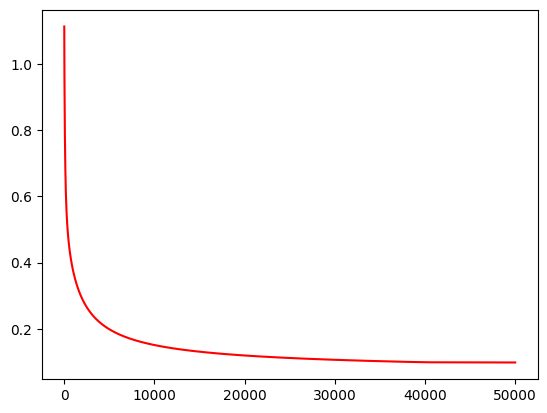

predicted: [0 1 0 1 1 1 0 0 2 2 0 2 2 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 2 1 1 0 2 2 2 1 2
 2 1 2 0 0 0 0 0]
label_true: [0 1 0 1 1 1 0 0 2 2 0 2 2 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 2 1 1 0 2 2 2 1 2
 2 1 2 0 0 0 0 0]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        11

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

[[18  0  0]
 [ 0 16  0]
 [ 0  0 11]]


In [83]:
main()